In [151]:
# based on 
# Bishop pattern recognition
# and maybe
# https://blog.wolfram.com/2019/08/22/embracing-uncertainty-better-model-selection-with-bayesian-linear-regression/

# also this:
# http://krasserm.github.io/2019/02/23/bayesian-linear-regression/

In [78]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np
import scipy.stats as stats

In [79]:
def model(x, w0, w1):    
    return w0 + w1*x

In [80]:
def gen_fake_data(N, a0, a1, noise_sd):
    x = np.random.uniform(-1, 1, size=N)
    y = model(x, a0, a1)
    noise = np.random.normal(0, noise_sd, size=N)
    return x, y+noise

In [81]:
def standard_deviation_to_precision(standard_deviation):
    return 1/standard_deviation**2

In [82]:
def precision_to_standard_deviation(precision):
    return 1/np.sqrt(precision)

In [83]:
def ln_like(x, y, beta, w0, w1):
    return -0.5 * beta * np.sum( np.square(y-model(x, w0, w1)) )

In [84]:
def ln_prior_2(alpha, w0, w1):
    w = np.array([w0, w1])
    return -0.5 * alpha * np.dot(w,w)

def ln_prior(w_prior, w0, w1):
    return w_prior.logpdf([w0, w1])

In [85]:
def ln_posterior(x, y, beta, alpha, w_prior, w0, w1):
    lnprob = ln_like(x, y, beta, w0, w1) 
#     lnprior = ln_prior(w_prior, w0, w1)
    lnprior = ln_prior_2(alpha, w0, w1)
    return lnprob, lnprior, lnprob + lnprior

In [86]:
N = 12
a0_true = -0.3
a1_true = 0.5
noise_sd = 0.2
beta = standard_deviation_to_precision(noise_sd)
x_true, y_true = gen_fake_data(N, a0_true, a1_true, noise_sd)

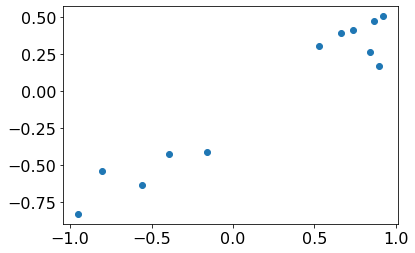

In [87]:
plt.figure()
plt.plot(x_true, y_true, 'o')

In [88]:
def weights_prior(alpha):
    """
    sd = 0.25 corresponds to a precision parameter of 2
    
    the weigths will be drawn from a gaussian with mean = 0 and sd = 1/sqrt(2)
    """
    
    sd = precision_to_standard_deviation(alpha)
    var = np.square(sd)
    
    rv = stats.multivariate_normal([0., 0.], [[var, 0], [0, var]])
    return rv

In [89]:
alpha = 2

In [90]:
precision_to_standard_deviation(alpha)

0.7071067811865475

In [91]:
w_prior = weights_prior(alpha)

In [92]:
w_prior.rvs()

array([-0.37372381,  0.93932586])

In [93]:
ln_prior(w_prior, 0, 1)

-2.1447298858494

In [94]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
x = x.ravel()
y = y.ravel()

In [95]:
def draw_xyz(x, y, z):
    fig2 = plt.figure(figsize=(4,4))
    ax2 = fig2.add_subplot(111)
    ax2.scatter(x, y, c=z)
    ax2.scatter(a0_true, a1_true, c='C1', s=100)
    ax2.set_xlim(-1,1)
    ax2.set_ylim(-1,1)

In [96]:
def draw_prior(rv):
    x, y = np.mgrid[-1:1:.01, -1:1:.01]
    pos = np.dstack((x, y))
    fig2 = plt.figure(figsize=(4,4))
    ax2 = fig2.add_subplot(111)
    ax2.contourf(x, y, rv.pdf(pos))
    ax2.set_xlim(-1,1)
    ax2.set_ylim(-1,1)

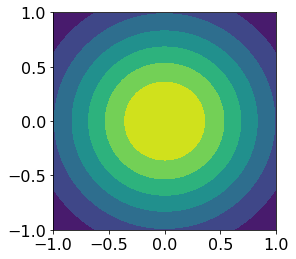

In [97]:
draw_prior(w_prior)

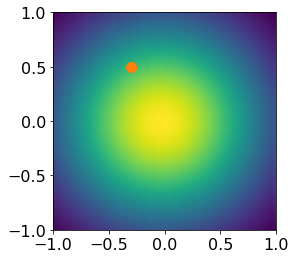

In [98]:
draw_xyz(x, y, w_prior.pdf(np.column_stack((x, y))))

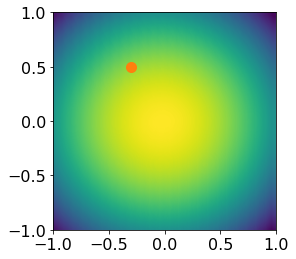

In [99]:
draw_xyz(x, y, w_prior.logpdf(np.column_stack((x, y))))

In [100]:
# these two should be the same up to a constant

p1=[]
p2=[]
w0s=[]
for i in range(100):
    w0, w1 = w_prior.rvs()
    w0s.append(w0)
    p1.append(ln_prior_2(alpha, w0, w1))
    p2.append(ln_prior(w_prior, w0, w1))
p1 = np.array(p1)
p2 = np.array(p2)
w0s = np.array(w0s)

In [101]:
fac = p1[0]-p2[0]

In [102]:
# they are off by a constant in log space which is a additive constant.

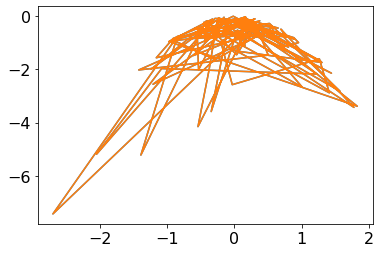

In [103]:
plt.figure()
plt.plot(w0s, p1)
plt.plot(w0s, p2+fac)

In [104]:
w0, w1 = w_prior.rvs()
lnlike, lnprior, lnposterior = ln_posterior(x_true, y_true, beta, alpha, w_prior, w0, w1)
print(lnlike, lnprior, lnposterior)

-118.15718728374668 -0.6860146937643806 -118.84320197751106


In [105]:
def compute_lnprob_on_grid(x, y, rv):
    abc = np.asarray([ln_posterior(x_true, y_true, beta, alpha, w_prior, w0, w1) for (w0, w1) in zip(x, y)])
    lnlike = abc[:,0]
    lnprior = abc[:,1]
    lnposterior = abc[:,2]
    
    return np.array(lnlike), np.array(lnprior), np.array(lnposterior)

In [106]:
lnlike_grid, lnprior_grid, lnprob_grid = compute_lnprob_on_grid(x, y, w_prior)

In [107]:
lnprob_grid.shape

(40000,)

In [108]:
lnprob_grid

array([-418.04380385, -414.82939538, -411.63124896, ..., -237.14960389,
       -238.42998106, -239.72662027])

In [109]:
a0_true

-0.3

In [110]:
np.sum(x*np.exp(lnprob_grid))

-3.014958985337942

In [111]:
np.mean(x * lnprob_grid)

-1.5334345324599068

In [112]:
np.mean(y * lnprob_grid)

32.52248089206018

In [113]:
a1_true

0.5

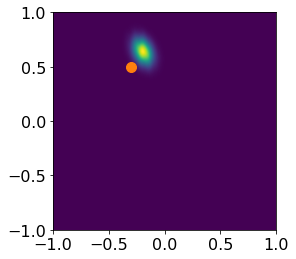

In [114]:
draw_xyz(x, y, np.exp(lnprob_grid))
# draw_xyz(x, y, lnprob_grid)

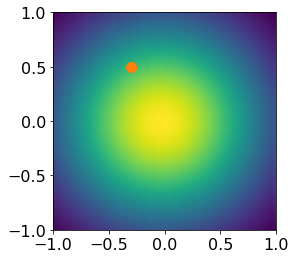

In [115]:
draw_xyz(x, y, np.exp(lnprior_grid))
# draw_xyz(x, y, lnprior_grid)

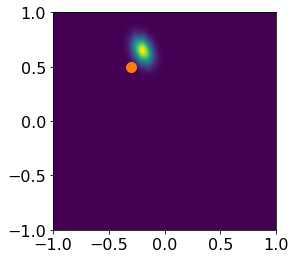

In [116]:
draw_xyz(x, y, np.exp(lnlike_grid))
# draw_xyz(x, y, lnlike_grid)

In [117]:
np.argmax(lnlike_grid)

16766

In [118]:
def get_maxL_pars(x,y,lnlike):
    maxid = np.argmax(lnlike)
    return x[maxid], y[maxid]

In [119]:
w0_maxL, w1_maxL = get_maxL_pars(x, y, lnlike_grid)

In [120]:
x_domain = np.linspace(-1, 1, 100)

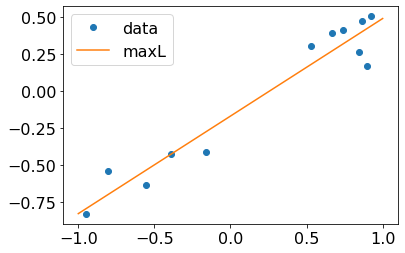

In [121]:
plt.figure()
plt.plot(x_true, y_true, 'o', label='data')
plt.plot(x_domain, model(x_domain, w0_maxL, w1_maxL), label='maxL')
plt.legend()

In [122]:
def draw_grid(z):
    x, y = np.mgrid[-1:1:.01, -1:1:.01]
    pos = np.dstack((x, y))
    fig2 = plt.figure(figsize=(4,4))
    ax2 = fig2.add_subplot(111)
    ax2.contourf(x, y, z)
    ax2.set_xlim(-1,1)
    ax2.set_ylim(-1,1)

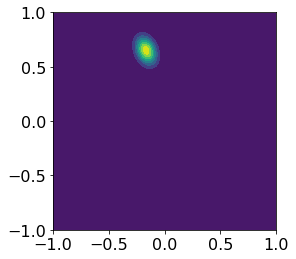

In [123]:
draw_grid(np.exp(lnprob_grid).reshape(200,200))

In [124]:
# how do i marginalise and compute p(w1) and p(w0)?
# to compute the marginalise it's easy if we put it back into
# a grid and then sum along each axis.
# this sum along each axis keep the other axis (parameter) constant
# https://share.cocalc.com/share/2c4cfce284fe4bc15e0ec91d074a4a6dc4ccf073/sheet01.html?viewer=share

In [125]:
grid_lnprob_grid = np.exp(lnprob_grid).reshape(200,200)

In [126]:
def marginalise(grid, axis, norm=True):
    marg = grid.sum(axis=axis)
    if norm:
        marg = marg/marg.max()
    return marg    

In [127]:
marg_w0 = marginalise(grid_lnprob_grid, axis=1) # this is p(w0) = int p(w0,w1)*dw1
marg_w1 = marginalise(grid_lnprob_grid, axis=0) # this is p(w1) = int p(w0,w1)*dw0

In [128]:
prior_marg_w0 = marginalise(np.exp(lnprior_grid).reshape(200,200), axis=1)
prior_marg_w1 = marginalise(np.exp(lnprior_grid).reshape(200,200), axis=0)

In [129]:
w0_array = np.arange(-1,1,.01)
w1_array = np.arange(-1,1,.01)

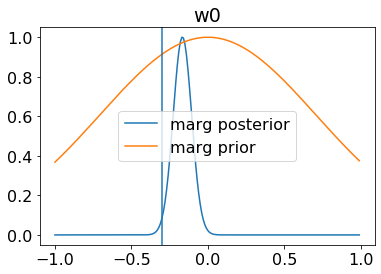

In [130]:
plt.figure()
plt.plot(w0_array, marg_w0, label='marg posterior')
plt.plot(w0_array, prior_marg_w0, label='marg prior')
plt.axvline(a0_true)
plt.title("w0")
plt.legend()

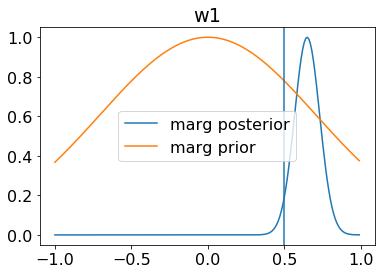

In [131]:
plt.figure()
plt.plot(w1_array, marg_w1, label='marg posterior')
plt.plot(w1_array, prior_marg_w1, label='marg prior')
plt.axvline(a1_true)
plt.title("w1")
plt.legend()

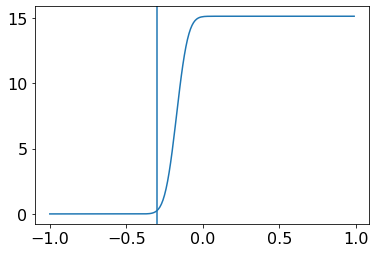

In [132]:
plt.plot(w0_array, np.cumsum(marg_w0))
plt.axvline(a0_true)

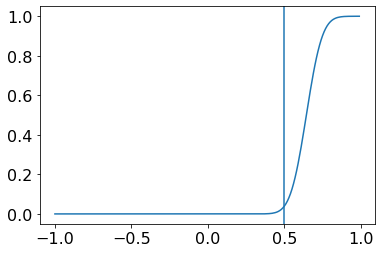

In [133]:
plt.plot(w1_array, np.cumsum(marg_w1)/np.cumsum(marg_w1).max())
plt.axvline(a1_true)


In [134]:
np.percentile(np.cumsum(marg_w1)/np.cumsum(marg_w1).max(), [5,50,90])

array([1.76029926e-79, 1.34708381e-15, 9.63472999e-01])

In [135]:
np.mean(marg_w0)

0.07556669621861856

In [136]:
a0_true

-0.3

In [137]:
a1_true

0.5

In [138]:
w0_array[np.argmax(marg_w0)]

-0.16999999999999926

In [139]:
# expectation value
#
np.sum(w0_array*marg_w0**2)

-1.780641572775835

In [140]:
# expectation value
#
np.sum(w1_array*marg_w1**2)

9.435366882945328

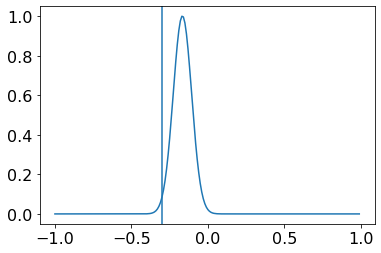

In [141]:
plt.plot(w0_array, marg_w0)
plt.axvline(a0_true)

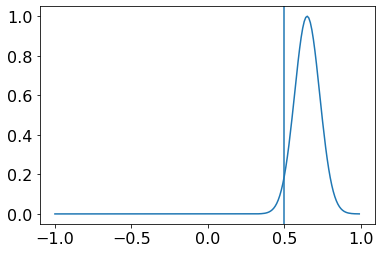

In [142]:
plt.plot(w1_array, marg_w1)
plt.axvline(a1_true)

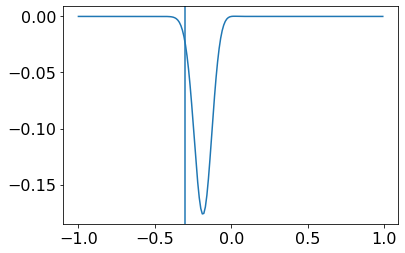

In [143]:
plt.plot(w0_array, w0_array*marg_w0)
plt.axvline(a0_true)

In [144]:
np.percentile(w0_array*np.cumsum(marg_w0), [50])

array([6.69699255e-15])

In [145]:
np.percentile(np.cumsum(marg_w0), [5, 50, 90])

array([4.37685363e-33, 1.50692850e+01, 1.51133392e+01])

In [146]:
np.percentile(np.cumsum(marg_w1), [5, 50, 90])

array([3.61888980e-78, 2.76938585e-14, 1.98074423e+01])

In [147]:
7.00504133e-04

0.000700504133

In [159]:
norm = stats.norm(1)

In [160]:
norm.mean()

1.0

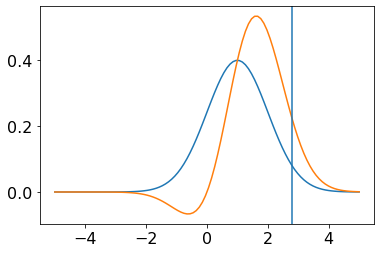

In [149]:
xs = np.linspace(-5, 5,100)
ys = norm.pdf(xs)
plt.plot(xs, ys)

plt.plot(xs, xs*ys)

plt.axvline(np.sum(xs*ys**2))

In [174]:
np.sum([xs[i]*ys[i] for i in range(len(xs))])

9.898674785002123

# predictive distribution

In [150]:
# In practice, we are not usually interested in the value of the weights itself but rather in making predictions of y for new values of x.
# This requires that we evaluate the predictive distribution defined by

$$
\begin{align}
p(y|\mathbf{y}, \alpha, \beta) = \int p(y|\mathbf{w}, \beta) p(\mathbf{w}|\mathbf{y}, \alpha, \beta) d\mathbf{w}
\end{align}
$$

where $$\mathbf{y}$$ is the vector of target values from the training set

$$p(t|\mathbf{x},\mathbf{y},\alpha, \beta) = \mathcal{N}(y|\mathbf{m}_N^{T} \phi(\mathbf{x}), \sigma_N^2)$$

where 

$$\sigma_N^2(\mathbf{x}) = 1/\beta + \phi(\mathbf{x})^T \mathbf{S}_N\phi(\mathbf{x})$$

# modify this so that i can compute the likelihood incrementally